# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [6]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

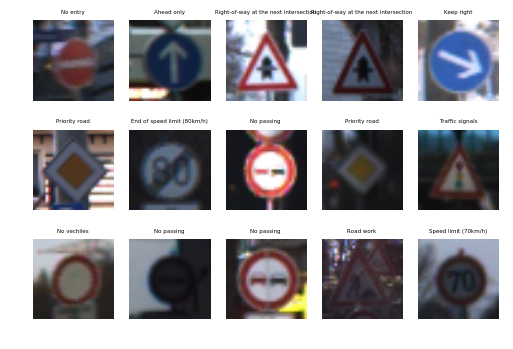

In [7]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import matplotlib.pyplot as plt
from random import randint
import numpy as np
import math
import csv
%matplotlib inline

number_of_test_images_to_show = 15
indexes_of_test_images_to_show = np.random.choice(len(X_train), number_of_test_images_to_show)

label_to_title = []

def read_signnames(filename):
    with open(filename, 'rt', encoding='utf8') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        return [row[1] for row in spamreader if row[0] != 'ClassId']

def show_images(images, labels, indexes_of_images_to_show, cmap = None):
    assert len(images) == len(labels)
    
    images_per_row = 5
    images_per_colon = math.ceil(len(indexes_of_images_to_show) / images_per_row)
    cur_image = 1
    
    fig = plt.figure()
    
    for index in indexes_of_images_to_show:
        image = images[index]
        label = labels[index]
        
        subplot = fig.add_subplot(images_per_colon, images_per_row, cur_image)
        plt.axis('off')
        plt.imshow(image, cmap = cmap)
        subplot.set_title(label_to_title[label], fontsize=4)
        
        cur_image += 1

label_to_title = read_signnames('signnames.csv') 
show_images(X_train, y_train, indexes_of_test_images_to_show)

In [8]:
### To start off let's do a basic data summary.

from itertools import groupby

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_test[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

for key, group in groupby(y_train):
    print("Class:", key, "\tName:", label_to_title[key], "\tCount:", len(list(group)), )

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Class: 0 	Name: Speed limit (20km/h) 	Count: 210
Class: 1 	Name: Speed limit (30km/h) 	Count: 2220
Class: 2 	Name: Speed limit (50km/h) 	Count: 2250
Class: 3 	Name: Speed limit (60km/h) 	Count: 1410
Class: 4 	Name: Speed limit (70km/h) 	Count: 1980
Class: 5 	Name: Speed limit (80km/h) 	Count: 1860
Class: 6 	Name: End of speed limit (80km/h) 	Count: 420
Class: 7 	Name: Speed limit (100km/h) 	Count: 1440
Class: 8 	Name: Speed limit (120km/h) 	Count: 1410
Class: 9 	Name: No passing 	Count: 1470
Class: 10 	Name: No passing for vechiles over 3.5 metric tons 	Count: 2010
Class: 11 	Name: Right-of-way at the next intersection 	Count: 1320
Class: 12 	Name: Priority road 	Count: 2100
Class: 13 	Name: Yield 	Count: 2160
Class: 14 	Name: Stop 	Count: 780
Class: 15 	Name: No vechiles 	Count: 630
Class: 16 	Name: Vechiles over 3.5 metric tons prohibited 	Count: 420
Class: 17 

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

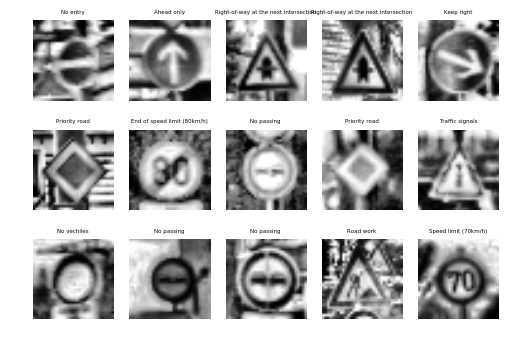

In [9]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

import cv2
from sklearn.preprocessing import LabelBinarizer

def normalize_image(image):
    a = 0.1
    b = 0.9
    x_min = 0.
    x_max = 255.
    return a + ((image-x_min) * (b - a)) / (x_max - x_min)

def normailize_images(images):
    return [normalize_image(image) for image in images]

def preprocess_image(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    clahe_image = clahe.apply(gray_image)
    eq_image = cv2.equalizeHist(clahe_image)
    return eq_image;

def preprocess_images(images):
    return [preprocess_image(image) for image in images]

def binarize_labels(labels, classes_count):
    encoder = LabelBinarizer()
    encoder.fit(range(classes_count))
    labels = encoder.transform(labels)
    
    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    labels = labels.astype(np.float32)
    
    return labels

def flatten_images(images):
    return [np.array(image, dtype=np.float32).flatten() for image in images]

def reshape_images(images, num_channels):
    return [image.reshape([image_shape[0],image_shape[1],num_channels]) for image in images]

y_train_bin = binarize_labels(y_train, n_classes)
y_test_bin = binarize_labels(y_test, n_classes)

X_train_prep = preprocess_images(X_train)
X_test_prep = preprocess_images(X_test)

X_train_norm = normailize_images(X_train_prep)
X_test_norm = normailize_images(X_test_prep)

X_train_flat = flatten_images(X_train_norm)
X_test_flat = flatten_images(X_test_norm)

num_channels = 1

X_train_shaped = reshape_images(X_train_norm, num_channels)
X_test_shaped = reshape_images(X_test_norm, num_channels)

features_count = len(X_train_flat[0])
labels_count = n_classes

show_images(X_train_prep, y_train, indexes_of_test_images_to_show, cmap = 'gray')

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
I converted image to grayscale, as research (http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) suggests grayscale performs better. Further, by advise form the same research, I performed local and global contrast normalization. Next I normalized the image to be within 0.1 to 0.9 range. Finally I have reshaped the image.

In [77]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

from sklearn.model_selection import train_test_split

train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_shaped,
    y_train_bin,
    test_size=0.1,
    train_size=0.9,
    random_state=936602)

train_features_np, valid_features_np, train_labels_np, valid_labels_np = np.array(train_features), np.array(valid_features), np.array(train_labels), np.array(valid_labels)

test_features, test_labels = X_test_shaped, y_test_bin

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
I have allocated 90% of data for training, and 10% for validation.

In [88]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

# Configuration

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 32         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Reguralization adjustment.
beta = 0.001

# Helper functions from https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights, biases

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer, weights, biases


features = tf.placeholder(tf.float32, shape=[None, image_shape[0], image_shape[1], num_channels])
labels = tf.placeholder(tf.float32, shape=[None, labels_count])


layer_conv1, weights_conv1, bias_conv1 = \
    new_conv_layer(input=features,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)
    
layer_conv2, weights_conv2, bias_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)
    
layer_flat, num_features = flatten_layer(layer_conv2)

layer_fc1, weights_fc1, bias_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

layer_fc2, weights_fc2, bias_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=labels_count,
                         use_relu=False)

prediction = tf.nn.softmax(layer_fc2)

# Cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=labels)

# Training loss
loss = tf.reduce_mean(cross_entropy +
    beta*tf.nn.l2_loss(weights_conv1) +
    beta*tf.nn.l2_loss(weights_conv2) +
    beta*tf.nn.l2_loss(bias_conv1) +
    beta*tf.nn.l2_loss(bias_conv1) +
    beta*tf.nn.l2_loss(weights_fc1) +
    beta*tf.nn.l2_loss(weights_fc2) +
    beta*tf.nn.l2_loss(bias_fc1) +
    beta*tf.nn.l2_loss(bias_fc2))

prediction_argmax = tf.argmax(prediction, 1)
labels_argmax = tf.argmax(labels, 1)

# Determine if the predictions are correct
is_correct_prediction = tf.equal(prediction_argmax, labels_argmax)

# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
This is a convolutional neural netowk, with 64 features and filter size 5. After that there is a 2 fully connected layers that rely on a linear WX + b funciton, where W are weights, B is bias and X is a variable. On top of that, I have applied a softmax function to even out the numbers. I applied a mean reduction method for loss training.

Epoch  2/50:   0%|          | 4/4411 [00:00<02:46, 26.53batches/s]

Train accuracy at 0.05078125
Validation accuracy at 0.03125


Epoch  3/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.05078125
Validation accuracy at 0.03125


Epoch  4/50:   0%|          | 4/4411 [00:00<02:12, 33.38batches/s]

Train accuracy at 0.87890625
Validation accuracy at 0.84375


Epoch  5/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.87890625
Validation accuracy at 0.84375


Epoch  6/50:   0%|          | 4/4411 [00:00<02:13, 33.12batches/s]

Train accuracy at 0.9453125
Validation accuracy at 0.8984375


Epoch  7/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.9453125
Validation accuracy at 0.8984375


Epoch  8/50:   0%|          | 4/4411 [00:00<02:09, 33.99batches/s]

Train accuracy at 0.984375
Validation accuracy at 0.953125


Epoch  9/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.984375
Validation accuracy at 0.953125


Epoch 10/50:   0%|          | 4/4411 [00:00<02:15, 32.63batches/s]

Train accuracy at 0.96875
Validation accuracy at 0.96875


Epoch 11/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.96875
Validation accuracy at 0.96875


Epoch 12/50:   0%|          | 4/4411 [00:00<02:06, 34.83batches/s]

Train accuracy at 0.984375
Validation accuracy at 0.94921875


Epoch 13/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.984375
Validation accuracy at 0.94921875


Epoch 14/50:   0%|          | 4/4411 [00:00<02:07, 34.62batches/s]

Train accuracy at 0.984375
Validation accuracy at 0.96875


Epoch 15/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.984375
Validation accuracy at 0.96875


Epoch 16/50:   0%|          | 4/4411 [00:00<02:01, 36.23batches/s]

Train accuracy at 0.9921875
Validation accuracy at 0.9609375


Epoch 17/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.9921875
Validation accuracy at 0.9609375


Epoch 18/50:   0%|          | 4/4411 [00:00<01:57, 37.51batches/s]

Train accuracy at 1.0
Validation accuracy at 0.9765625


Epoch 19/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 1.0
Validation accuracy at 0.9765625


Epoch 20/50:   0%|          | 4/4411 [00:00<01:52, 39.05batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.98046875


Epoch 21/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.98046875


Epoch 22/50:   0%|          | 4/4411 [00:00<01:56, 37.72batches/s]

Train accuracy at 0.984375
Validation accuracy at 0.9765625


Epoch 23/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.984375
Validation accuracy at 0.9765625


Epoch 24/50:   0%|          | 4/4411 [00:00<02:01, 36.24batches/s]

Train accuracy at 1.0
Validation accuracy at 0.984375


Epoch 25/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 1.0
Validation accuracy at 0.984375


Epoch 26/50:   0%|          | 5/4411 [00:00<01:43, 42.65batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.98046875


Epoch 27/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.98046875


Epoch 28/50:   0%|          | 5/4411 [00:00<01:41, 43.21batches/s]

Train accuracy at 0.9921875
Validation accuracy at 0.984375


Epoch 29/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.9921875
Validation accuracy at 0.984375


Epoch 30/50:   0%|          | 5/4411 [00:00<01:45, 41.59batches/s]

Train accuracy at 1.0
Validation accuracy at 0.9609375


Epoch 31/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 1.0
Validation accuracy at 0.9609375


Epoch 32/50:   0%|          | 5/4411 [00:00<01:43, 42.66batches/s]

Train accuracy at 1.0
Validation accuracy at 0.984375


Epoch 33/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 1.0
Validation accuracy at 0.984375


Epoch 34/50:   0%|          | 4/4411 [00:00<01:51, 39.51batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.99609375


Epoch 35/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.99609375


Epoch 36/50:   0%|          | 5/4411 [00:00<01:46, 41.48batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.9765625


Epoch 37/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.9765625


Epoch 38/50:   0%|          | 5/4411 [00:00<01:43, 42.66batches/s]

Train accuracy at 1.0
Validation accuracy at 0.9921875


Epoch 39/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 1.0
Validation accuracy at 0.9921875


Epoch 40/50:   0%|          | 5/4411 [00:00<01:43, 42.54batches/s]

Train accuracy at 1.0
Validation accuracy at 0.98046875


Epoch 41/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 1.0
Validation accuracy at 0.98046875


Epoch 42/50:   0%|          | 5/4411 [00:00<01:43, 42.55batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.9921875


Epoch 43/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.9921875


Epoch 44/50:   0%|          | 5/4411 [00:00<01:44, 42.07batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.9765625


Epoch 45/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.9765625


Epoch 46/50:   0%|          | 5/4411 [00:00<01:43, 42.69batches/s]

Train accuracy at 0.98828125
Validation accuracy at 0.9765625


Epoch 47/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 0.98828125
Validation accuracy at 0.9765625


Epoch 48/50:   0%|          | 5/4411 [00:00<01:44, 42.35batches/s]

Train accuracy at 1.0
Validation accuracy at 0.98828125


Epoch 49/50:   0%|          | 0/4411 [00:00<?, ?batches/s]

Train accuracy at 1.0
Validation accuracy at 0.98828125


Epoch 50/50:   0%|          | 5/4411 [00:00<01:53, 38.81batches/s]

Train accuracy at 0.99609375
Validation accuracy at 0.9765625


Epoch 50/50: 100%|██████████| 4411/4411 [01:43<00:00, 42.78batches/s]


Train accuracy at 0.99609375
Validation accuracy at 0.9765625


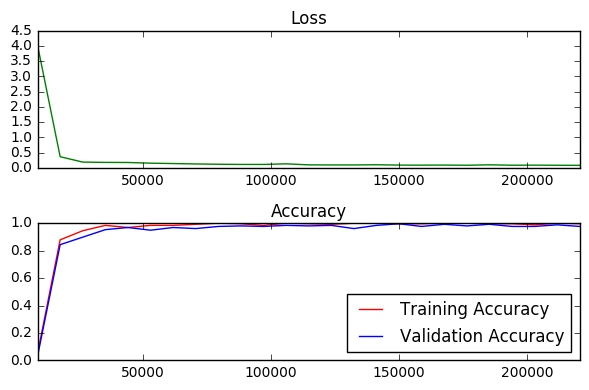

In [92]:
### Train your model here.
### Feel free to use as many code cells as needed.

from tqdm import tqdm
import matplotlib.pyplot as plt

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

epochs = 50
batch_size = 8
learning_rate = 0.0001
logging_sample_size = 256

# Gradient Descent
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
desired_output_points = 25
log_batch_step = math.ceil(len(train_features)*epochs/batch_size/desired_output_points)
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

session = tf.Session()

session.run(init)
batch_count = int(math.ceil(len(train_features)/batch_size))

for epoch_i in range(epochs):
    # Progress bar
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')

    # The training cycle
    for batch_i in batches_pbar:
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        batch_features = train_features[batch_start:batch_start + batch_size]
        batch_labels = train_labels[batch_start:batch_start + batch_size]

        # Run optimizer and get loss
        _, l = session.run(
            [optimizer, loss],
            feed_dict={features: batch_features, labels: batch_labels})

        # Log
        if not (epoch_i * batch_count + batch_i) % log_batch_step:
            # Calculate Training and Validation accuracy (estimate)
            training_indexes = np.random.choice(len(train_features), logging_sample_size)
            training_accuracy = session.run(accuracy, feed_dict={features: train_features_np[training_indexes], labels: train_labels_np[training_indexes]})
            
            validation_indexes = np.random.choice(len(valid_features), logging_sample_size)
            validation_accuracy = session.run(accuracy, feed_dict={features: valid_features_np[validation_indexes], labels: valid_labels_np[validation_indexes]})

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)
                
    print('Train accuracy at {}'.format(training_accuracy))
    print('Validation accuracy at {}'.format(validation_accuracy))
        
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
I used Adam optimizer with batch size 256, 5 epochs and learning rate 0.001.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
I performed multiple measurements with different set of hyperparameters. I was trying to debug my problem to see where the loss might occur using graphs, as shown in previous lab: https://github.com/udacity/CarND-TensorFlow-Lab

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

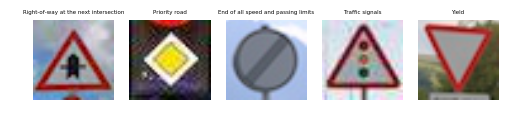

In [62]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

from scipy import misc

custom_images_filenames = ['right_of_way.jpg', 'priority_road.jpg', 'nolimit.jpg', 'traffic_signals.jpg', 'yield.jpg']
custom_images = [misc.imread(filename) for filename in custom_images_filenames]
custom_images_labels = [11,12,32,26,13]

show_images(custom_images, custom_images_labels, range(len(custom_images)))

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
Image number 4, with the traffic light, can be easily confused with another one with a exclamation point. This is also emphasized by the fact that we recognize images in black-and-white and adjust the contrast ratio.

In [95]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

custom_images_labels_bin = binarize_labels(custom_images_labels, n_classes)
custom_images_prep = preprocess_images(custom_images)
custom_images_norm = normailize_images(custom_images_prep)
custom_images_shaped = reshape_images(custom_images_prep, num_channels)

custom_feed_dict = {features: custom_images_shaped, labels: custom_images_labels_bin}

custom_prediction = session.run(prediction, feed_dict=custom_feed_dict)
custom_prediction_argmax = session.run(prediction_argmax, feed_dict=custom_feed_dict)

custom_accuracy = session.run(accuracy, feed_dict=custom_feed_dict)

print(custom_accuracy)
print(custom_prediction_argmax)
print(custom_images_labels)

0.8
[11 12 32 18 13]
[11, 12, 32, 26, 13]


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
Model only showed 60% accuracy on captured images. The last image with a yield sign must have been in different rotation then the one we have in the set, and thus the result. We can improve this result by feeding more rotated images in the training set. Image number 4 can be easily mistaken for the same sign with an exclamation point, which is what happened. To improve this resul we can try using colors with the image, and use contrast increase less agressively.

Actual: End of all speed and passing limits 
Best guess: ['End of all speed and passing limits', 'End of no passing', 'Go straight or right', 'End of speed limit (80km/h)'] 

Actual: Traffic signals 
Best guess: ['General caution', 'Pedestrians', 'Traffic signals', 'Go straight or left'] 

Actual: Right-of-way at the next intersection 
Best guess: ['Right-of-way at the next intersection', 'Beware of ice/snow', 'Pedestrians', 'Road narrows on the right'] 

Actual: Priority road 
Best guess: ['Priority road', 'Roundabout mandatory', 'End of speed limit (80km/h)', 'End of no passing by vechiles over 3.5 metric tons'] 

Actual: Yield 
Best guess: ['Yield', 'Ahead only', 'Turn right ahead', 'Keep left'] 

    Actual  -> Best guess, by level of confidence


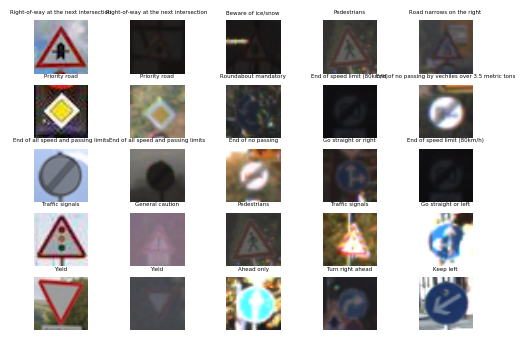

In [96]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

def show_images_with_samples(images, labels, best_guess_labels, library_images, libarary_labels):
    assert len(images) == len(labels)
    assert len(library_images) == len(libarary_labels)
    assert len(labels) == len(best_guess_labels)
    
    images_per_row = len(best_guess_labels[0]) + 1 if len(best_guess_labels) > 0 else 0
    image_count = images_per_row * len(labels)
    images_per_colon = math.ceil(image_count / images_per_row)
    cur_image = 1
    
    fig = plt.figure()
    
    for index, label in enumerate(labels):
        image = images[index]
        
        subplot = fig.add_subplot(images_per_colon, images_per_row, cur_image)
        plt.axis('off')
        plt.imshow(image)
        subplot.set_title(label_to_title[label], fontsize = 4)
        
        cur_image += 1
        
        for label in best_guess_labels[index]:
            image_index = np.argwhere(libarary_labels == label)[0]
            library_image = library_images[image_index][0]

            subplot = fig.add_subplot(images_per_colon, images_per_row, cur_image)
            plt.axis('off')
            plt.imshow(library_image)
            subplot.set_title(label_to_title[label], fontsize = 4)
            
            cur_image += 1

custom_top_k = tf.nn.top_k(layer_fc2, k=4)
custom_top_k_res = session.run(custom_top_k, feed_dict=custom_feed_dict)

actual_to_best_guess = { label : custom_top_k_res.indices[i] for i, label in enumerate(custom_images_labels)}

for actual in actual_to_best_guess:
    print("Actual:", label_to_title[actual], "\nBest guess:", [label_to_title[guess] for guess in actual_to_best_guess[actual]], "\n")
    
print("    Actual  -> Best guess, by level of confidence")
show_images_with_samples(custom_images, custom_images_labels, custom_top_k_res.indices, X_train, y_train)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
It seems like softmax only gives 1 or 0, which suggests that we have pretty big difference between the predictions, as well as large number of classes. So I used tf.nn.top_k on the fully connected layer result. Yield sign scored correct result on a second guess, which is promising. Yet the traffic light recognition only came as result number 21, in the middle of the set.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
I have reshaped images manually. After that I used imread to load the image. Then I used the same model and session I had previously for all images for the new images.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.